In [1]:
import numpy as np
from netCDF4 import Dataset
import datetime
import glob
import os
import matplotlib.pyplot as plt
import cartopy
from matplotlib import gridspec
import cartopy.crs as ccrs
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")

In [2]:
ctrl = 'rosie_UCL_CTL_NOSIT_ASSIM_r243541_dcarneir/'
base = 'rosie_UCL_BASELINE_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA1_r243541_dcarneir/'
nine = 'rosie_UCL_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA09_r243541_dcarneir/'
six = 'rosie_UCL_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA06_r243541_dcarneir/'
larm = 'rosie_UCL_SIT_ASSIM_CS2_BRISTOL_SNFOAM_ALPHA1_r243541_dcarneir/'
cpom = 'rosie_UCL_SIT_ASSIM_CS2_CPOM_SNFOAM_ALPHA1_r243541_dcarneir/'
smlg = 'rosie_UCL_SIT_ASSIM_CS2_AWI_SNLG_ALPHA1_r243541_dcarneir/'
awi = 'rosie_UCL_SIT_ASSIM_CS2_AWI_SNAWI_ALPHA1_r243541_dcarneir/'
unc = 'rosie_UCL_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA1_NEW_OBERR_r243541_dcarneir/'

titles = ['CTRL','BASE','\u03B1_0.9', '\u03B1_0.6','FB_LARM','FB_CPOM','SN_SMLG','SN_AWI','UNC']
folders = [ctrl, base, nine, six, larm, cpom, smlg, awi,unc]

In [3]:
datapath = '/Users/carmennab/Dropbox/met_office/data/validation/OIB/matched/'

days = np.arange(0,212)
dates = [datetime.date(2016,10,1)+datetime.timedelta(days=np.int(days)) for days in days]

all_lons = {} ; all_lats = {} ; all_diffs = {} ; all_rs = {} ; all_rmses = {}; all_obs = {} ; all_foams = {}
for folder,title in zip(folders,titles):
    diffs = [] ; lons = [] ; lats = [] ; obs = [] ; foams = []
    for day in days:
        date = dates[day].strftime('%Y%m%d')
        filepath = datapath + folder + date + 'T0000Z_sitfb_oo_fdbk.nc'
        if os.path.exists(filepath) == True:
            file = Dataset(filepath)
            foam = np.array(file['SIT_Hx'][:,0])
            ob = np.array(file['SIT_OBS'][:,0])
            lon = np.array(file['LONGITUDE'])
            lat = np.array(file['LATITUDE'])
            
            obs.extend(ob) ; foams.extend(foam) ; lons.extend(lon) ; lats.extend(lat)

    lats = np.array(lats) ; lons = np.array(lons) ; obs = np.array(obs) ; foams = np.array(foams)
    all_lats[title] = lats ; all_lons[title] = lons ; all_diffs[title] = foams - obs 
    all_obs[title] = obs ; all_foams[title] = foams
    
    print(title,np.nanmin(all_diffs[title]),np.nanmax(all_diffs[title])) #check whether colorbar needs extending

CTRL -3.526639 0.8237842
BASE -3.671153 0.7198427
α_0.9 -3.630072 0.57197213
α_0.6 -3.7378554 0.49732763
FB_LARM -3.6660023 0.7031136
FB_CPOM -3.6600995 0.79948187
SN_SMLG -3.7161832 1.338303
SN_AWI -3.6801066 1.634982
UNC -3.8487961 0.41285962


### compare base and unc

In [4]:
### SIT < 1 m
base_foams = all_foams['BASE']
base_obs = all_obs['BASE']

unc_foams = all_foams['UNC']
unc_obs = all_obs['UNC']

mask = np.where(base_obs<1)
rstats = linregress(base_obs[mask],base_foams[mask])
base_r = np.round(rstats.rvalue,decimals=2)
base_rmse = np.round(np.sqrt(np.nanmean((base_foams[mask]-base_obs[mask])**2)),decimals=2)

mask = np.where(unc_obs<1)
rstats = linregress(unc_obs[mask],unc_foams[mask])
unc_r = np.round(rstats.rvalue,decimals=2)
unc_rmse = np.round(np.sqrt(np.nanmean((unc_foams[mask]-unc_obs[mask])**2)),decimals=2)

print(base_rmse,unc_rmse)
print(base_r,unc_r)

0.41 0.32
0.82 0.82


### plot figs

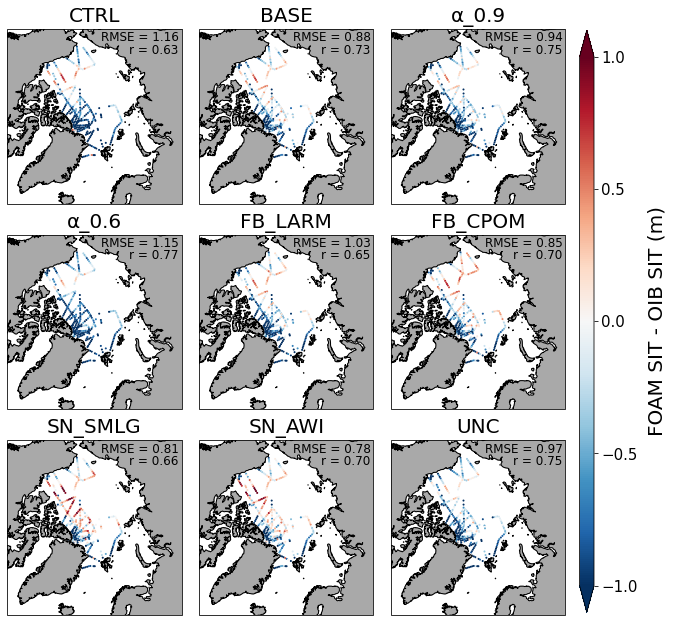

In [5]:
fig = plt.figure(figsize=(10,11))
spec = gridspec.GridSpec(ncols=3, nrows=3, hspace=0.1, wspace=0.1)

for count, title in enumerate(titles):
    
    ax = fig.add_subplot(spec[count],projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    
    p_map = ax.scatter(all_lons[title],all_lats[title],c = all_diffs[title], vmin = -1, vmax = 1, cmap = 'RdBu_r', s=1, transform=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.coastlines()
    
    rstats = linregress(all_obs[title],all_foams[title])
    r = np.round(rstats.rvalue,decimals=2)
    rmse = np.round(np.sqrt(np.nanmean((all_foams[title]-all_obs[title])**2)),decimals=2)
    
    ax.text(0.7, 0.86, ('r = '+ '%.2f'%r), fontsize=12 ,transform = ax.transAxes)
    ax.text(0.54, 0.93, ('RMSE = '+ '%.2f'%rmse), fontsize=12 ,transform = ax.transAxes)

    ax.set_title((title), fontsize=20,pad=7)
    if count == 2: 
        cbar_ax = fig.add_axes([0.92, 0.136, 0.02, 0.735]) # x, y, width, height
        a = fig.colorbar(p_map, cax=cbar_ax,extend='both')
        a.ax.tick_params(labelsize=15)
        a.set_ticks([-1,-0.5,0,0.5,1])
        a.set_label("FOAM SIT - OIB SIT (m)", fontsize = 20, labelpad = 10)
           
plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/FOAM sensitivity/main_figs/oib_maps.png',dpi=400, bbox_inches="tight")